In [ ]:

!pip install -U scikit-learn imbalanced-learn imblearn


In [1]:

import pandas as pd
import matplotlib.pyplot as plt 

df = pd.read_csv('./card_credit_fraud.csv', sep=';', decimal=',', low_memory=False)

print(df['type'].value_counts())

df.info()


type
CASH_OUT    366632
PAYMENT     329867
CASH_IN     218938
TRANSFER     86301
DEBIT         6475
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008213 entries, 0 to 1008212
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   transactionId   1008213 non-null  int64  
 1   step            1008213 non-null  int64  
 2   type            1008213 non-null  object 
 3   amount          1008213 non-null  float64
 4   nameOrig        1008213 non-null  object 
 5   oldbalanceOrg   1008213 non-null  float64
 6   newbalanceOrig  1008213 non-null  float64
 7   nameDest        1008213 non-null  object 
 8   oldbalanceDest  1008213 non-null  float64
 9   newbalanceDest  1008213 non-null  float64
 10  isFraud         1008213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 84.6+ MB




### Préparation de la data et entaînement du modèle RandomForest



In [2]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 

# mapping to replace string to int
type_mapping = { 'CASH_OUT': 1, 'PAYMENT': 2, 'CASH_IN': 3, 'TRANSFER' : 4, 'DEBIT': 5 }
df['type'] = df['type'].map(type_mapping)

df.info()

# features
X = df[['type', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

# target
y = df['isFraud']

# split dataset for training && test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier()
model.fit(X_train, y_train)

pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008213 entries, 0 to 1008212
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   transactionId   1008213 non-null  int64  
 1   step            1008213 non-null  int64  
 2   type            1008213 non-null  int64  
 3   amount          1008213 non-null  float64
 4   nameOrig        1008213 non-null  object 
 5   oldbalanceOrg   1008213 non-null  float64
 6   newbalanceOrig  1008213 non-null  float64
 7   nameDest        1008213 non-null  object 
 8   oldbalanceDest  1008213 non-null  float64
 9   newbalanceDest  1008213 non-null  float64
 10  isFraud         1008213 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 84.6+ MB


,importance
step,0.731389
newbalanceDest,0.073732
amount,0.071356
oldbalanceOrg,0.066848
oldbalanceDest,0.026941
newbalanceOrig,0.015915
type,0.013818



### Affichage de la matrice de confusion



[0 0 0 ... 0 0 0]


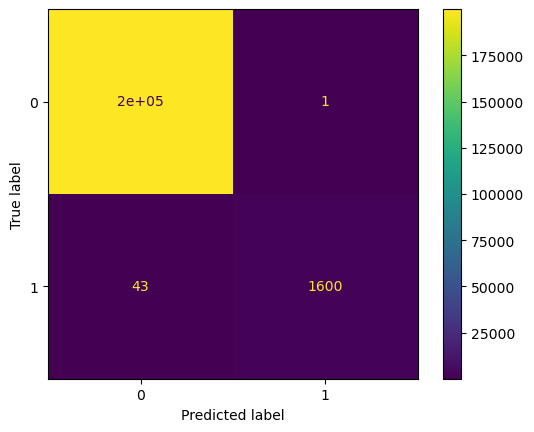

0.9997817925740046
[[199999      1]
 [    43   1600]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       1.00      0.97      0.99      1643

    accuracy                           1.00    201643
   macro avg       1.00      0.99      0.99    201643
weighted avg       1.00      1.00      1.00    201643



In [3]:

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# prediction 
y_pred = model.predict(X_test)

print(y_pred)

# evaluation 
accuracy = accuracy_score(y_test, y_pred)
_confusion_matrix = confusion_matrix(y_test, y_pred)
_classification_report = classification_report(y_test, y_pred)

# display matrix confusion
display = ConfusionMatrixDisplay(confusion_matrix=_confusion_matrix)
display.plot()
plt.show()

print(accuracy)
print(_confusion_matrix)
print(_classification_report)


In [11]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score)

parameters = { 'n_estimators': [3, 15, 35], 'criterion': ['entropy', 'gini'], 'max_depth': [3, 10] }

grid = GridSearchCV(model, parameters, scoring=f1_scorer, cv=5)
grid = grid.fit(X_train, y_train)

print(grid.best_estimator_)

opti_model = grid.best_estimator_
opti_model.fit(X_train, y_train)

print(opti_model.score(X_train, y_train))
print(opti_model.score(X_test, y_test))
print(opti_model.score(X, y))


RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=35)
0.9997979096668609
0.9997718740546411
0.9997927025340876


In [ ]:

### Courbe ROC



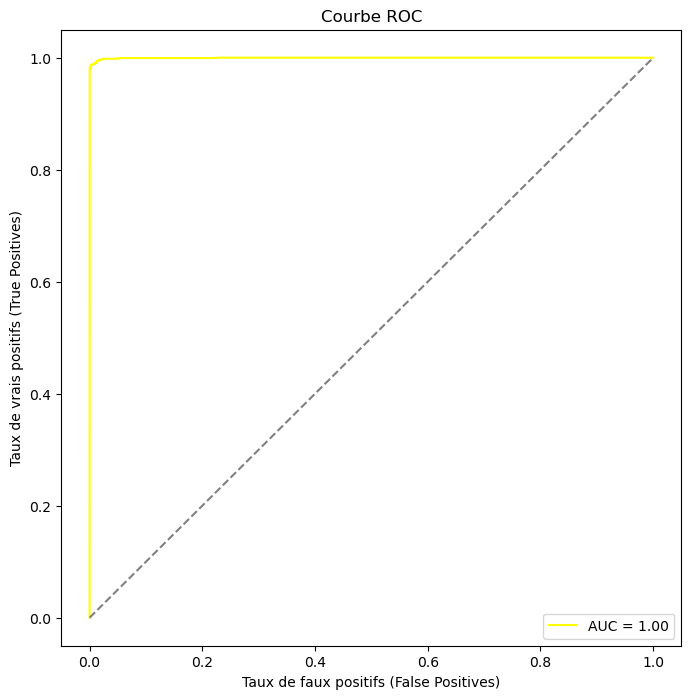

In [12]:

from sklearn.metrics import roc_curve, roc_auc_score

y_probs = opti_model.predict_proba(X_test)[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_probs)

auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fp, tp, color='yellow', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de faux positifs (False Positives)')
plt.ylabel('Taux de vrais positifs (True Positives)')
plt.title('Courbe ROC')
plt.legend()
plt.show()



In [ ]:


### UNDERSAMPLING avec matrice de confusion



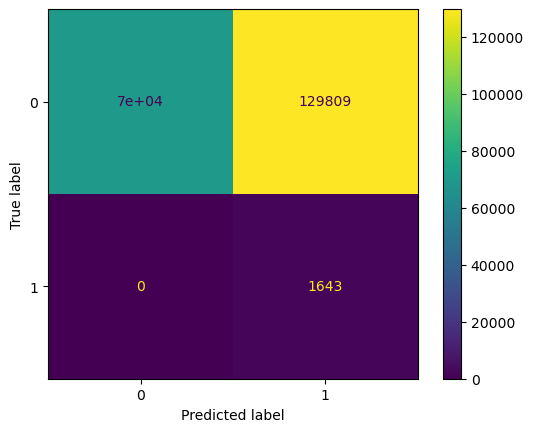

0.35624345997629475
[[ 70191 129809]
 [     0   1643]]
              precision    recall  f1-score   support

           0       1.00      0.35      0.52    200000
           1       0.01      1.00      0.02      1643

    accuracy                           0.36    201643
   macro avg       0.51      0.68      0.27    201643
weighted avg       0.99      0.36      0.52    201643



In [13]:

import pickle
from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_train_undersampled, y_train_undersampled = nm.fit_resample(X_train, y_train)

opti_model.fit(X_train_undersampled, y_train_undersampled)

with open('random_forest_undersampling.pkl', 'wb') as file:
    pickle.dump(opti_model, file)

y_pred = opti_model.predict(X_test)

# evaluation 
accuracy = accuracy_score(y_test, y_pred)
_confusion_matrix = confusion_matrix(y_test, y_pred)
_classification_report = classification_report(y_test, y_pred)

# display matrix confusion
display = ConfusionMatrixDisplay(confusion_matrix=_confusion_matrix)
display.plot()
plt.show()

print(accuracy)
print(_confusion_matrix)
print(_classification_report)


In [ ]:


### Courbe ROC UNDERSAMPLING



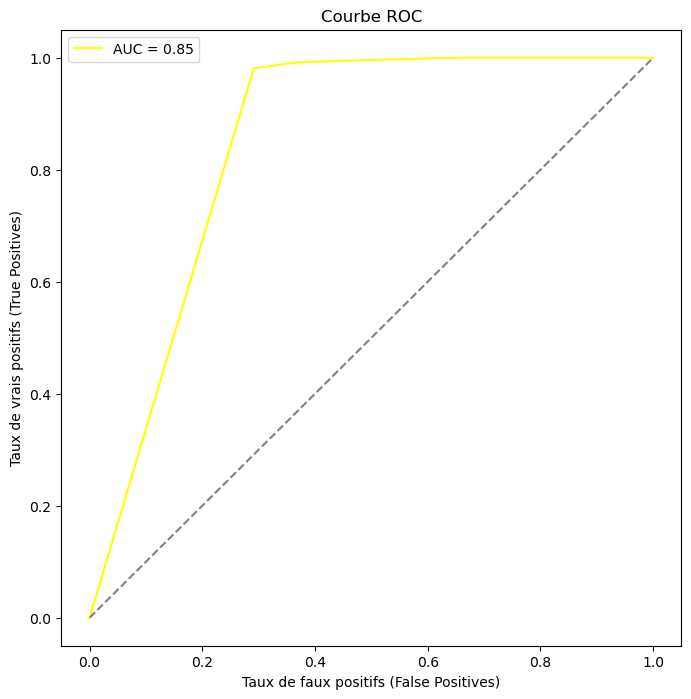

In [14]:

y_probs = opti_model.predict_proba(X_test)[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_probs)

auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fp, tp, color='yellow', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de faux positifs (False Positives)')
plt.ylabel('Taux de vrais positifs (True Positives)')
plt.title('Courbe ROC')
plt.legend()
plt.show()


In [ ]:


### OVERSAMPLING avec matrice de confusion



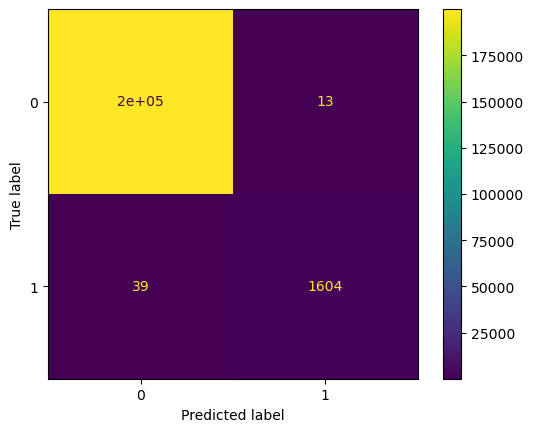

0.9997421184965508
[[199987     13]
 [    39   1604]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       0.99      0.98      0.98      1643

    accuracy                           1.00    201643
   macro avg       1.00      0.99      0.99    201643
weighted avg       1.00      1.00      1.00    201643



In [15]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

opti_model.fit(X_train_oversampled, y_train_oversampled)

with open('random_forest_oversampling.pkl', 'wb') as file:
    pickle.dump(opti_model, file)

y_pred = opti_model.predict(X_test)

# evaluation 
accuracy = accuracy_score(y_test, y_pred)
_confusion_matrix = confusion_matrix(y_test, y_pred)
_classification_report = classification_report(y_test, y_pred)

# display matrix confusion
display = ConfusionMatrixDisplay(confusion_matrix=_confusion_matrix)
display.plot()
plt.show()

print(accuracy)
print(_confusion_matrix)
print(_classification_report)


In [ ]:


### Courbe ROC OVERSAMPLING



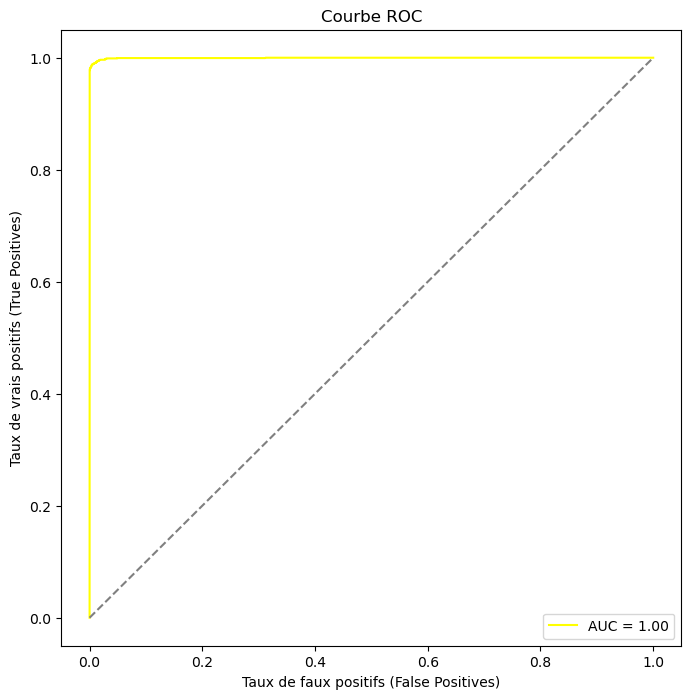

In [16]:

y_probs = opti_model.predict_proba(X_test)[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_probs)

auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fp, tp, color='yellow', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de faux positifs (False Positives)')
plt.ylabel('Taux de vrais positifs (True Positives)')
plt.title('Courbe ROC')
plt.legend()
plt.show()
